In [1]:
# Load datasets
from datasets import load_dataset

train_dataset = load_dataset(
    "csv",
    data_files="https://huggingface.co/datasets/RatchapolSamalee/Wongnai2025_augment_data_for_fine-tuning/resolve/main/train_og_data.csv"
)["train"]

test_dataset = load_dataset(
    "csv",
    data_files="https://huggingface.co/datasets/RatchapolSamalee/Wongnai2025_augment_data_for_fine-tuning/resolve/main/test_data.csv"
)["train"]

val_dataset = load_dataset(
    "csv",
    data_files="https://huggingface.co/datasets/RatchapolSamalee/Wongnai2025_augment_data_for_fine-tuning/resolve/main/validate_data.csv"
)["train"]

print(train_dataset)
print(test_dataset)
print(val_dataset)


Dataset({
    features: ['review_body', 'stars', 'labels'],
    num_rows: 10890
})
Dataset({
    features: ['review_body', 'stars', 'labels'],
    num_rows: 3112
})
Dataset({
    features: ['review_body', 'stars', 'labels'],
    num_rows: 1556
})


In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

def preprocess_function(examples):
    return tokenizer(
        examples["review_body"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/10890 [00:00<?, ? examples/s]

In [3]:
label_map = {"negative": 0, "positive": 1}

def encode_labels(example):
    if "labels" in example and isinstance(example["labels"], str):
        return {"labels": label_map[example["labels"]]}

# map labels ให้ครบทุกชุด
train_dataset = train_dataset.map(encode_labels)
val_dataset = val_dataset.map(encode_labels)
test_dataset = test_dataset.map(encode_labels)

# shuffle ชุดข้อมูล
train_dataset = train_dataset.shuffle(seed=42)
val_dataset = val_dataset.shuffle(seed=42)
test_dataset = test_dataset.shuffle(seed=42)

Map:   0%|          | 0/10890 [00:00<?, ? examples/s]

Map:   0%|          | 0/1556 [00:00<?, ? examples/s]

Map:   0%|          | 0/3112 [00:00<?, ? examples/s]

In [4]:
for dset in [train_dataset, val_dataset, test_dataset]:
    dset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

labels = np.array(train_dataset["labels"])  # แปลงจาก tensor → numpy

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)


Class Weights: tensor([7.4691, 0.5359])


In [6]:
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(
            weight=class_weights.to(model.device)
        )
        loss = loss_fct(
            logits.view(-1, self.model.config.num_labels),
            labels.view(-1)
        )

        return (loss, outputs) if return_outputs else loss


In [7]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed
import numpy as np
from sklearn.metrics import f1_score

set_seed(42)


# Load Pretrained Model

model = AutoModelForSequenceClassification.from_pretrained(
    "airesearch/wangchanberta-base-att-spm-uncased",
    num_labels=2
)


# ฟังก์ชันวัดผล F1 

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, preds, average="macro")}


# Training Arguments 

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",       
    learning_rate=3e-5,                
    warmup_ratio=0.1,                  
    per_device_train_batch_size=16,    
    num_train_epochs=5,                
    weight_decay=0.01,                 
    fp16=True,                         
    adam_beta1=0.9,                    
    adam_beta2=0.999,                  
    adam_epsilon=1e-8,                 
    logging_dir="./logs",             
    logging_strategy="epoch",
    load_best_model_at_end=True,       
    metric_for_best_model="f1",        
    greater_is_better=True,            
    save_strategy="epoch",             
    lr_scheduler_type="linear"         
)


# Trainer

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train

trainer.train()


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_7735/1191738973.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,F1
1,0.478000,0.637759,0.834191
2,0.327500,0.296381,0.908356
3,0.173400,0.498231,0.886698
4,0.108200,0.624834,0.890968
5,0.049100,0.687759,0.882445


TrainOutput(global_step=3405, training_loss=0.22725857974149058, metrics={'train_runtime': 190.3649, 'train_samples_per_second': 286.03, 'train_steps_per_second': 17.887, 'total_flos': 7163198482176000.0, 'train_loss': 0.22725857974149058, 'epoch': 5.0})

In [8]:
trainer.save_model("./wangchanberta-finetuned-raw-wongnai2025")
tokenizer.save_pretrained("./wangchanberta-finetuned-raw-wongnai2025")

('./wangchanberta-finetuned-raw-wongnai2025/tokenizer_config.json',
 './wangchanberta-finetuned-raw-wongnai2025/special_tokens_map.json',
 './wangchanberta-finetuned-raw-wongnai2025/sentencepiece.bpe.model',
 './wangchanberta-finetuned-raw-wongnai2025/added_tokens.json',
 './wangchanberta-finetuned-raw-wongnai2025/tokenizer.json')


 Classification Report:
              precision    recall  f1-score   support

    negative     0.7892    0.7644    0.7766       191
    positive     0.9846    0.9866    0.9856      2921

    accuracy                         0.9730      3112
   macro avg     0.8869    0.8755    0.8811      3112
weighted avg     0.9726    0.9730    0.9728      3112



<Figure size 500x500 with 0 Axes>

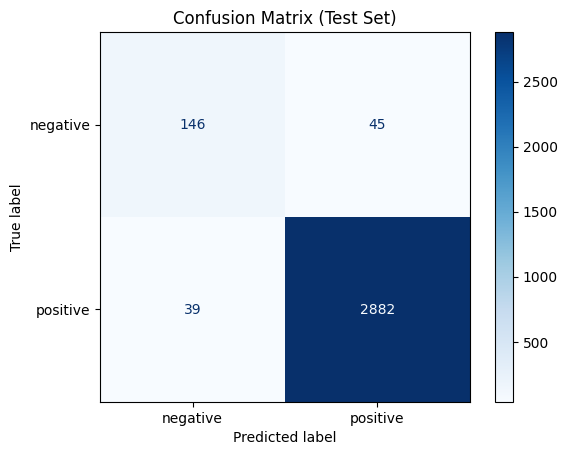

In [9]:
# Evaluate model performance on test set

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ทำนาย test set
predictions = trainer.predict(test_dataset)

#ดึงค่าทำนายและค่าจริง
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Classification Report:"
print("\n Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["negative", "positive"],
    digits=4
))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()
